In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

In [3]:
# Loading the dataset
df = pd.read_csv('./data/credit_risk_dataset.csv')

# 1. Define Target Variable (y) BEFORE dropping columns
y = df['default_risk']

# 2. Drop specified columns from Features (X)
# Requirements: Drop ['default_risk', 'customer_financial_statement', 'customer_id', 'risk_category']
cols_to_drop = ['default_risk', 'customer_financial_statement', 'customer_id', 'risk_category']
# Using errors='ignore' in case some columns don't exist
X_raw = df.drop(columns=cols_to_drop, errors='ignore')

print(f"Original shape: {df.shape}")
print(f"Features shape: {X_raw.shape}")

Original shape: (1500, 18)
Features shape: (1500, 15)


In [4]:
# 3. Encoding: One-Hot Encoding for categorical variables
# Identifying categorical columns (object type or specific known categoricals)
# Note: 'risk_category' was removed. 'sentiment' and 'financial_stress_level' might be categorical.
categorical_cols = X_raw.select_dtypes(include=['object']).columns.tolist()

# Also checking for other potential categoricals that might be encoded as integers but should be OHE
# Based on previous notebook, 'financial_stress_level' might be one, but let's stick to object types + sentiment if it's there.
# If 'sentiment' is text/object, it will be caught above.

print(f"Categorical columns to Encode: {categorical_cols}")

# Use pd.get_dummies for One-Hot Encoding (drop_first=True to avoid dummy variable trap if linear, though RF is robust)
X = pd.get_dummies(X_raw, columns=categorical_cols, drop_first=True)

# 4. Data Split: 80-20 Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")

Categorical columns to Encode: ['employment_type', 'education_level', 'marital_status', 'region', 'financial_stress_level']
Training Features Shape: (1200, 24)
Testing Features Shape: (300, 24)


In [5]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# 5. Cross Validation: 5-fold CV
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')

print(f"5-Fold CV Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

# Train the model on the full training set
rf_model.fit(X_train, y_train)

print("Random Forest Model Trained Successfully!")

5-Fold CV Accuracy Scores: [0.9625     0.95833333 0.95       0.96666667 0.9625    ]
Mean CV Accuracy: 0.9600
Random Forest Model Trained Successfully!


Test Accuracy: 0.97
ROC-AUC Score: 0.9963494884480522

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       191
           1       0.99      0.93      0.96       109

    accuracy                           0.97       300
   macro avg       0.97      0.96      0.97       300
weighted avg       0.97      0.97      0.97       300



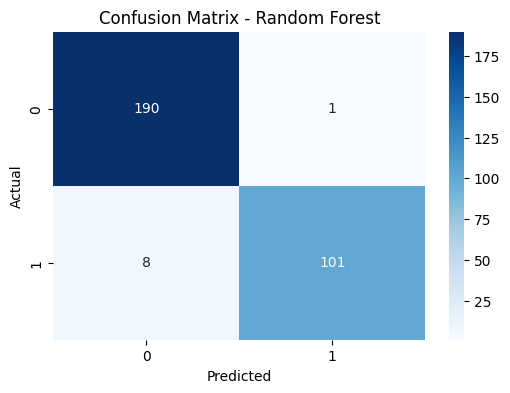

In [6]:
# Make predictions
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1] # Probability for ROC-AUC

# Metrics
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Visualization
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

C:\Users\Iman Haikal\AppData\Local\Temp\ipykernel_12380\692992306.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


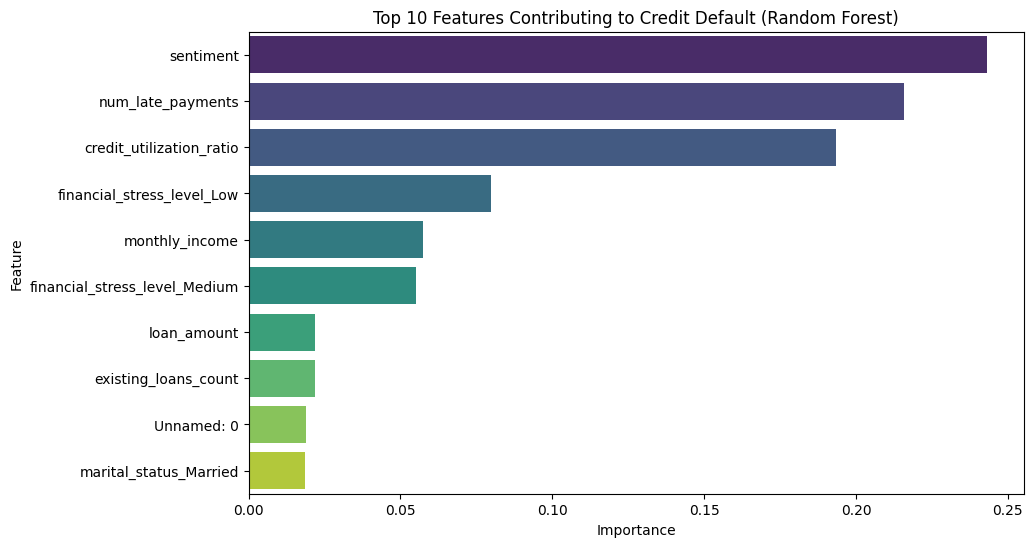

In [7]:
# Extract importance
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort and Plot
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Features Contributing to Credit Default (Random Forest)')
plt.show()

In [8]:
import os
import google.generativeai as genai
from dotenv import load_dotenv

# 1. Setup Gemini (Reusing team's setup)
load_dotenv()
api_key = os.getenv("GEMINI_API_KEY")

if not api_key:
    print("⚠️ Warning: GEMINI_API_KEY not found in .env file. AI interpretation skipped.")
else:
    genai.configure(api_key=api_key)
    model = genai.GenerativeModel('gemini-3-flash-preview')

    # 2. Prepare the data for the AI
    # We convert our metrics and feature importance into a text string
    top_features = feature_importance_df.head(5).to_string(index=False)
    accuracy_val = accuracy_score(y_test, y_pred)
    roc_val = roc_auc_score(y_test, y_prob)
    
    analysis_prompt = f"""
    You are a Senior Data Scientist in a bank.
    I have trained a Random Forest model to predict credit default risk.
    
    Here are the performance metrics:
    - Accuracy: {accuracy_val:.2f}
    - ROC-AUC Score: {roc_val:.2f}
    
    Here are the top 5 most important features driving the model:
    {top_features}
    
    Task:
    1. Summarize the model's performance (is it good for a bank?).
    2. Interpret the top features. Explain WHY these specific features might be predicting default risk based on financial logic.
    3. Provide a brief business recommendation on how to use this model.
    """

    print("🤖 Asking Gemini to interpret the results...\n")
    
    try:
        response = model.generate_content(analysis_prompt)
        print("--- AI Analysis Report ---")
        print(response.text)
        
        # Optional: Save this analysis to a text file for the final report
        with open("model_interpretation_RF.txt", "w") as f:
            f.write(response.text)
            
    except Exception as e:
        print(f"Error communicating with Gemini: {e}")

c:\Users\Iman Haikal\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Iman Haikal\AppData\Local\Temp\ipykernel_12380\1944310129.py:2: FutureWarning: 

All support for the `google.generativeai` package has ended. It will no longer be receiving 
updates or bug fixes. Please switch to the `google.genai` package as soon as possible.
See README for more details:

https://github.com/google-gemini/deprecated-generative-ai-python/blob/main/README.md

  import google.generativeai as genai


🤖 Asking Gemini to interpret the results...

--- AI Analysis Report ---
As a Senior Data Scientist at this bank, I have reviewed the results of your Random Forest model. While the metrics appear exceptional on the surface, they raise several critical "red flags" that we must address before this model can be considered for a production environment.

Here is my analysis and strategic recommendation.

---

### 1. Model Performance Summary: "Too Good to be True?"
While an **Accuracy of 0.97** and a **ROC-AUC of 1.00** look perfect on a slide deck, in the context of credit risk, they are highly concerning.

*   **The Leakage Warning:** A ROC-AUC of 1.00 (perfect separation between classes) almost never happens in real-world banking. It usually indicates **Data Leakage**. This means the model is likely "cheating" by using a feature that is only recorded *after* a customer has already defaulted (e.g., "account_closed_date" or "collection_agency_contact").
*   **Overfitting:** A perfect score 